lab set: total 50 samples
unlab set: total 50 samples
train set: total 50 samples
test set: total 50 samples


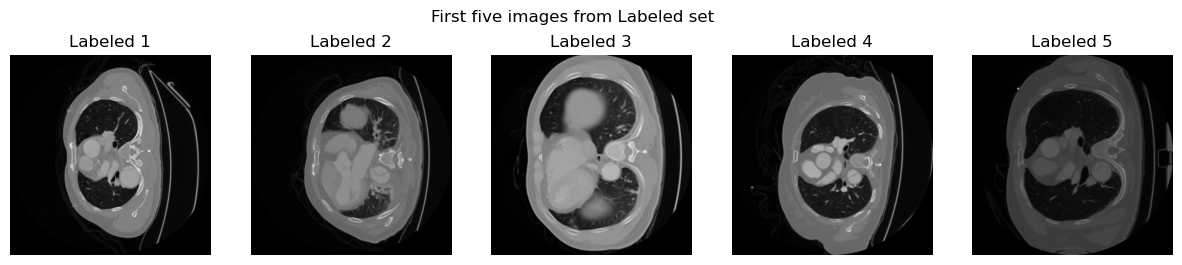

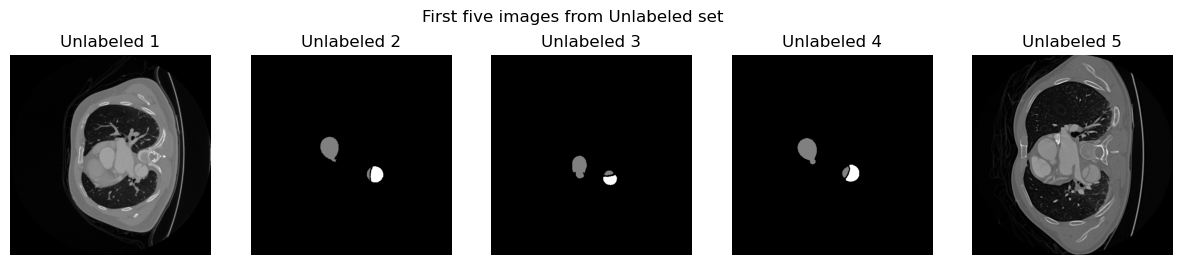

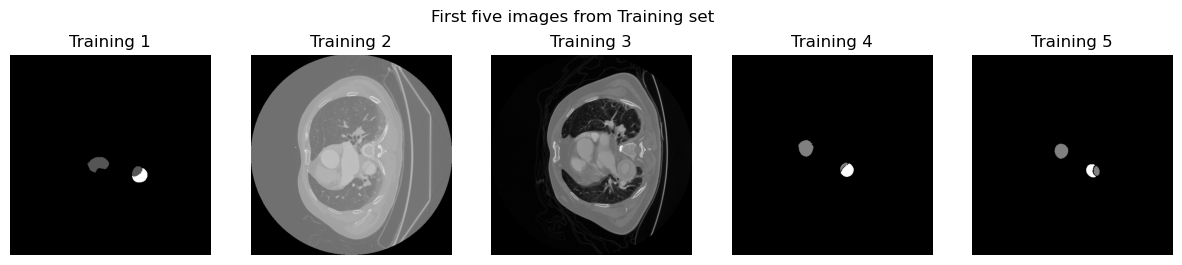

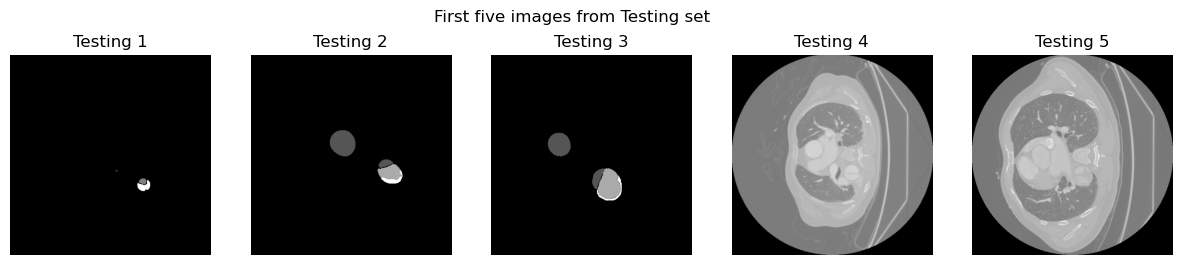

torch.Size([1, 512, 512, 328]) torch.Size([512, 512, 328])


In [49]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset
import h5py
import torchio as tio
import random

class AortaDissection(Dataset):
    
    def __init__(self, data_dir, split, aug_times=1, scale_range=(0.9, 1.1), rotate_degree=10):
        self.data_dir = data_dir
        self.split = split
        self.scale_range = scale_range
        self.rotate_degree = rotate_degree
        self.aug_times = aug_times

        self.transform = True if split in ['lab', 'train'] else False

        self.image_list = self.load_dataset()

        print("{} set: total {} samples".format(split, len(self.image_list)))
    
    def load_dataset(self):
        split_dir = os.path.join(self.data_dir, self.split)
        file_list = []
        for filename in os.listdir(split_dir):
            if filename.endswith('.nii.gz'):
                file_list.append(os.path.join(split_dir, filename))
        return file_list

    def __len__(self):
        return len(self.image_list) * self.aug_times if self.split != 'test' else len(self.image_list)

    def __getitem__(self, idx):
        image_path = self.image_list[idx % len(self.image_list)]
        nii_img = nib.load(image_path)
        image = nii_img.get_fdata().astype(np.float32)

        
        label_path = image_path.replace('images', 'labels')  
        nii_label = nib.load(label_path)
        label = nii_label.get_fdata().astype(np.float32)

        if self.transform:
            subject = tio.Subject(
                image=tio.ScalarImage(tensor=image[np.newaxis,]),
                label=tio.LabelMap(tensor=label[np.newaxis,])
            )
            RandomAffine = tio.RandomAffine(scales=self.scale_range, degrees=self.rotate_degree)
            randaff_sample = RandomAffine(subject)
            image = randaff_sample['image']['data']
            label = torch.unsqueeze(randaff_sample['label']['data'], 0)
        else:
            image = torch.from_numpy(image[np.newaxis,])
            label = torch.from_numpy(label)

        return {'image': image.float(), 'label': label.squeeze().long(), 'name': image_path}
    
def display_first_five_images(dataset, title):
    plt.figure(figsize=(15, 3))
    for i in range(5):
        image_path = dataset.image_list[i]
        nii_img = nib.load(image_path)
        image = nii_img.get_fdata()
        slice_index = image.shape[2] // 2
        selected_slice = image[:, :, slice_index]
        plt.subplot(1, 5, i + 1)
        plt.imshow(selected_slice, cmap='gray')
        plt.axis('off')
        plt.title(f'{title} {i+1}')

    plt.suptitle(f'First five images from {title} set')
    plt.show()
        

if __name__ == '__main__':
    data_dir = '/home/amishr17/aryan/data/'

    labset = AortaDissection(data_dir, split='lab')
    unlabset = AortaDissection(data_dir, split='unlab')
    trainset = AortaDissection(data_dir, split='train')
    testset = AortaDissection(data_dir, split='test')

    display_first_five_images(labset, 'Labeled')
    display_first_five_images(unlabset, 'Unlabeled')
    display_first_five_images(trainset, 'Training')
    display_first_five_images(testset, 'Testing')
    
   
    lab_sample = labset[0]
    print(lab_sample['image'].shape, lab_sample['label'].shape)